# Stock Price Movement Prediction
## Objective
Predict whether the closing price of an S&P 500 stock will increase or decrease on the next trading day based on the following features:
- Opening Price
- Highest Price
- Lowest Price
- Adjusted Close Price
- Trading Volume

## Data Description
- **Date Range**: 2010 to end of 2016
- **Companies**: 501 S&P 500 companies
- **Data Points**: 851,264 entries
- **Adjustments**: 140 stock splits adjusted in `prices-split-adjusted.csv`


## Importing Necessary Libraries
We'll import only the essential libraries required for data manipulation, visualization, and modeling with LSTM.

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve

# Deep Learning with TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam


# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot aesthetics
sns.set_theme(style="whitegrid", palette="muted")
%matplotlib inline

## Loading and Inspecting the Data
We'll load the dataset, inspect the first few rows, check for missing values, and understand the data types.

In [2]:
# from google.colab import drive
# from tensorflow.keras.optimizers import Adam
# import zipfile
# import os

# # Mount Google Drive
# drive.mount('/content/drive')

# # Define the path to the ZIP file and CSV file
# zip_file_path = '/content/drive/MyDrive/DSi/prices-split-adjusted.csv.zip'  # Adjust the path to match your file's location
# extract_to_path = '/content/drive/My Drive/DSi/'  # Folder to extract the ZIP file to
# csv_file_path = os.path.join(extract_to_path, 'prices-split-adjusted.csv')  # Path to the extracted CSV

# # Extract the ZIP file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

# # Load the dataset
# df = pd.read_csv(csv_file_path)

# # Display the first few rows of the dataset
# df.head()


In [3]:
# Load the dataset
df = pd.read_csv('../data/raw/prices-split-adjusted.csv')

df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
# Check the data types and non-null counts
print("\nData Information:")
df.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [5]:
# Check unique values
print("\nUnique Values per Column:")
df.nunique()


Unique Values per Column:


date        1762
symbol       501
open       97522
close      98520
low        97470
high       97784
volume    171073
dtype: int64

## Data Preprocessing
Handle missing values, create the target variable, and perform necessary feature engineering.

### Handling Missing Values
We'll impute missing values (if any) for numerical columns using the median strategy.

In [6]:
# Check for missing values
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [7]:
# Check for missing values
missing = df.isnull().sum()
missing_cols = missing[missing > 0]

if not missing_cols.empty:
    print("\nMissing Values:")
    print(missing_cols)

    # Impute missing values for numerical columns using median
    numerical_cols = ['open', 'close', 'low', 'high', 'volume']
    imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

    # Verify no missing values remain
    print("\nMissing Values After Imputation:")
    print(df.isnull().sum())
else:
    print("\nNo missing values found. Skipping imputation.")


No missing values found. Skipping imputation.


### Feature Engineering
Create additional features that may help in prediction.

In [8]:
# Create daily return as a feature
df['daily_return'] = (df['close'] - df['open']) / df['open']

# Create volatility feature
df['volatility'] = (df['high'] - df['low']) / df['open']

# Add moving averages
df['MA10'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=10).mean())
df['MA50'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=50).mean())

# Add Relative Strength Index (RSI)
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = df.groupby('symbol')['close'].transform(lambda x: calculate_rsi(x))

# Add Bollinger Bands
df['BB_upper'] = df['MA10'] + 2 * df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=10).std())
df['BB_lower'] = df['MA10'] - 2 * df.groupby('symbol')['close'].transform(lambda x: x.rolling(window=10).std())

# Drop any remaining missing values just in case
df = df.dropna()

print("\nData with new features:")
display(df.head())
print(df.columns.tolist())


Data with new features:


,date,symbol,open,close,low,high,volume,daily_return,volatility,MA10,MA50,RSI,BB_upper,BB_lower
49,2016-03-16,WLTW,120.349998,120.820000,119.010002,121.040001,562100.0,0.003905,0.016867,118.392999,113.938400,91.354161,122.369285,114.416713
50,2016-03-17,WLTW,121.010002,124.029999,119.449997,124.410004,809300.0,0.024957,0.040988,119.095999,113.902200,94.479467,124.280062,113.911936
51,2016-03-18,WLTW,124.250000,121.269997,120.089996,124.559998,1607300.0,-0.023984,0.035976,119.503999,113.927999,76.731648,124.663518,114.344479
52,2016-03-21,WLTW,120.860001,121.449997,119.139999,121.839996,1001300.0,0.004882,0.022340,119.953999,114.057999,73.094836,124.904214,115.003783
53,2016-03-22,WLTW,121.029999,121.470001,120.720001,122.910004,711400.0,0.003635,0.018095,120.429999,114.154999,70.198089,124.884430,115.975568


['date', 'symbol', 'open', 'close', 'low', 'high', 'volume', 'daily_return', 'volatility', 'MA10', 'MA50', 'RSI', 'BB_upper', 'BB_lower']


### Defining the Target Variable
We'll create a binary target variable indicating whether the closing price increases (1) or decreases (0) the next trading day.

In [9]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by symbol and date to ensure correct ordering
df = df.sort_values(by=['symbol', 'date'])

# # Create the target variable: 1 if next day's close > today's close, else 0
# df['target'] = df.groupby('symbol')['close'].shift(-1) > df['close']
# df['target'] = df['target'].astype(int) # Convert Target to Binary (1 or 0)

# Create the target variable: 1 if next day's close is at least 0.1% higher than today's close, else 0
threshold = 0.001  # 0.1% threshold
df['target'] = (df.groupby('symbol')['close'].shift(-1) - df['close']) / df['close'] >= threshold
df['target'] = df['target'].astype(int)  # Convert Target to Binary (1 or 0)


# Drop the last day for each symbol as it doesn't have a target
df = df.dropna(subset=['target'])

# Verify target distribution
print("Target distribution:\n", df['target'].value_counts())

Target distribution:
 target
0    426216
1    400499
Name: count, dtype: int64


In [10]:
print("\nSample data with target variable:")
df.head(10)


Sample data with target variable:


,date,symbol,open,close,low,high,volume,daily_return,volatility,MA10,MA50,RSI,BB_upper,BB_lower,target
23182,2010-03-16,A,23.884121,23.905579,23.762518,24.020029,3285900.0,0.000898,0.010782,23.713877,22.066238,78.441538,24.379716,23.048037,0
23650,2010-03-17,A,23.919886,23.876966,23.834049,24.062946,3926000.0,-0.001794,0.009569,23.781116,22.095994,80.533312,24.346614,23.215617,1
24118,2010-03-18,A,23.819742,23.934191,23.719599,24.020029,4494700.0,0.004805,0.012613,23.866952,22.131760,78.901711,24.143308,23.590597,0
24586,2010-03-19,A,23.905579,23.905579,23.698141,24.077253,5882500.0,0.000000,0.015859,23.885550,22.168526,73.170716,24.142159,23.628942,1
25054,2010-03-22,A,23.791130,24.120172,23.669527,24.198856,3946600.0,0.013830,0.022249,23.937053,22.210157,73.448260,24.145812,23.728293,1
25522,2010-03-23,A,24.163090,24.399142,24.077253,24.470672,5195800.0,0.009769,0.016282,23.997138,22.257511,76.012437,24.334595,23.659682,0
25990,2010-03-24,A,24.306152,24.248926,24.220314,24.399142,3791500.0,-0.002354,0.007357,24.014306,22.301574,75.308619,24.385642,23.642969,1
26458,2010-03-25,A,24.391989,24.713877,24.370529,24.856939,6941300.0,0.013196,0.019941,24.083691,22.360229,73.244141,24.661610,23.505771,0
26926,2010-03-26,A,24.785408,24.542204,24.399142,24.821173,4705800.0,-0.009812,0.017027,24.147353,22.412017,71.335500,24.776094,23.518612,1
27394,2010-03-29,A,24.542204,24.606581,24.520745,24.821173,5377600.0,0.002623,0.012241,24.225322,22.458512,69.550170,24.870600,23.580043,1


## Exploratory Data Analysis (EDA)
Understand the distribution of features and the target variable.

### Distribution of the Target Variable

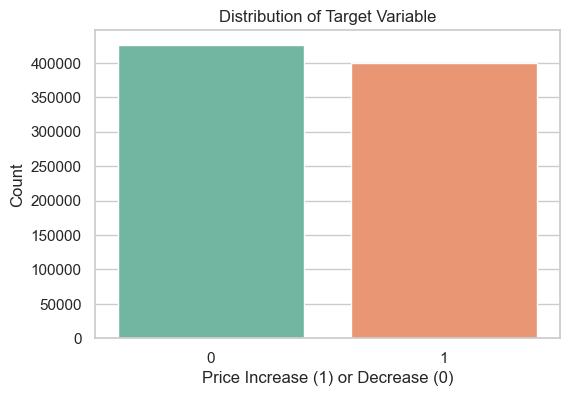


Class Distribution:
target
0    0.515554
1    0.484446
Name: proportion, dtype: float64


In [11]:
# Plot the distribution of the target variable
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df, palette='Set2')
plt.title('Distribution of Target Variable')
plt.xlabel('Price Increase (1) or Decrease (0)')
plt.ylabel('Count')
plt.show()

# Print the class balance
print("\nClass Distribution:")
print(df['target'].value_counts(normalize=True))

### Feature Distributions
Visualize the distribution of key numerical features.

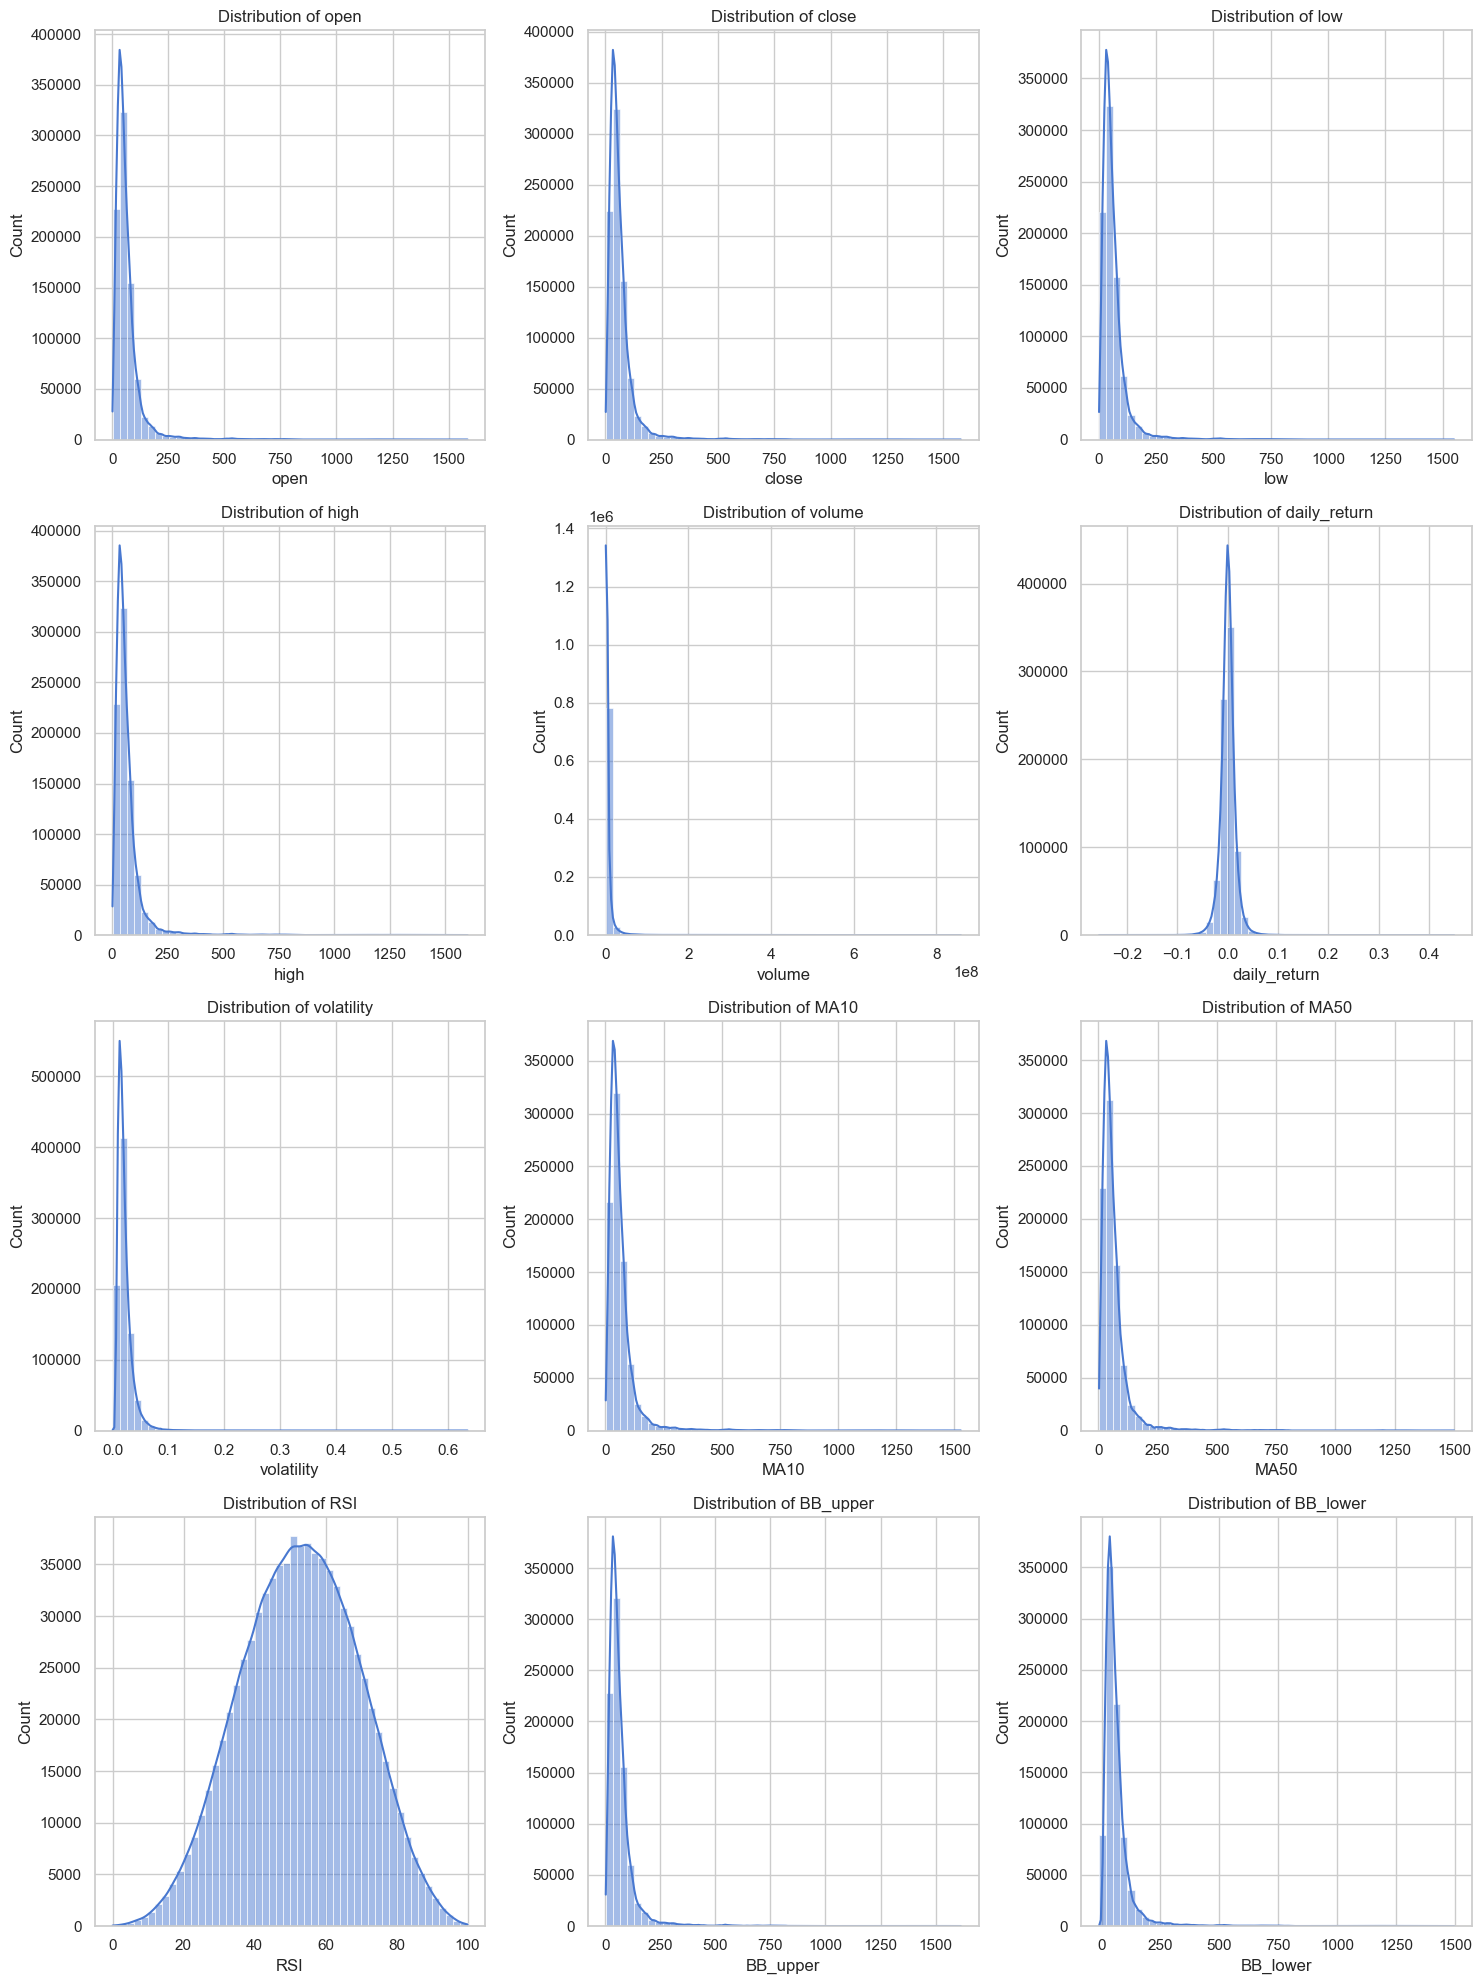

In [12]:
# Select numerical features for plotting
features = ['open', 'close', 'low', 'high', 'volume', 'daily_return', 'volatility', 'MA10', 'MA50', 'RSI', 'BB_upper', 'BB_lower']

# Determine the number of rows needed for subplots
import math
n_features = len(features)
n_rows = math.ceil(n_features / 3)

# Plot histograms
plt.figure(figsize=(15, 5 * n_rows))  # Adjust figure height dynamically
for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, 3, i)  # Adjust rows dynamically
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

#### Observation:

- **Open, Close, Low, High Prices:**
  - These features are heavily skewed to the right, with most values clustered in the lower range. We might need to scale or transform them (maybe with log scaling) to handle the skew if it impacts the model.

- **Volume:**
  - Trading volume is also very right-skewed, with a few really high values standing out as potential outliers. We’ll probably need to normalize this or deal with those outliers.

- **Daily Return:**
  - This one’s more balanced, with a nice symmetric distribution around zero. It looks like we have a good mix of small positive and negative returns.

- **Volatility:**
  - Volatility is skewed to the right, with most values near zero. Big price swings within a day seem to be rare.

## Data Preparation
Split the data into training and testing sets, and scale the features.

### Sequence Generation for LSTM
LSTM models require input data in the form of sequences. We'll define a `lookback period` (number of previous days) to create these sequences.

In [13]:
def create_sequences(df, lookback):
    """
    Create sequences of data for LSTM.

    Parameters:
    - df: pandas DataFrame
    - lookback: int, number of previous days to include in each sequence

    Returns:
    - X: numpy array of shape (samples, lookback, features)
    - y: numpy array of shape (samples,)
    """
    X, y = [], []
    symbols = df['symbol'].unique()

    for symbol in symbols:
        symbol_df = df[df['symbol'] == symbol].sort_values('date')
        data = symbol_df[['open', 'close', 'low', 'high', 'volume', 'daily_return', 'volatility', 'MA10', 'MA50', 'RSI', 'BB_upper', 'BB_lower']].values
        target = symbol_df['target'].values

        for i in range(len(data) - lookback):
            X.append(data[i:i+lookback])
            y.append(target[i+lookback])

    return np.array(X), np.array(y)

# Define the lookback period
LOOKBACK = 50

# Create sequences
X, y = create_sequences(df, LOOKBACK)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (801665, 50, 12)
Shape of y: (801665,)


### Splitting Data into Training and Testing Sets
We'll split the data based on chronological order to prevent data leakage. Training data will consist of sequences ending before 2016, and testing data will consist of sequences ending in 2016.

In [14]:
# Convert sequences back to DataFrame to access dates
def get_sequence_end_dates(df, lookback):
    """
    Get the end dates for each sequence.

    Parameters:
    - df: pandas DataFrame
    - lookback: int

    Returns:
    - dates: list of datetime objects
    """
    dates = []
    symbols = df['symbol'].unique()

    for symbol in symbols:
        symbol_df = df[df['symbol'] == symbol].sort_values('date')
        for i in range(lookback, len(symbol_df)):
            dates.append(symbol_df.iloc[i]['date'])

    return dates

sequence_dates = get_sequence_end_dates(df, LOOKBACK)

# Convert to pandas Series for easier indexing
sequence_dates = pd.Series(sequence_dates)

# Define the split date
split_date = pd.to_datetime('2016-01-01')

# Create boolean masks Train: (2010-2015) , Test: (2016)
train_mask = sequence_dates < split_date
test_mask = sequence_dates >= split_date

# Split the data
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (675852, 50, 12)
Testing set size: (125813, 50, 12)


### Scaling Features
We'll scale numerical features to ensure they contribute equally to the model. Scaling is performed based on the training data to prevent data leakage.

In [15]:
# Initialize StandardScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

# Reshape X_train and X_test to 2D for scaling
num_samples_train, timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)
X_test_reshaped = X_test.reshape(-1, num_features)

# Fit the scaler on training data and transform both training and testing data
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_samples_train, timesteps, num_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape[0], LOOKBACK, num_features)

print("\nFeatures scaled using StandardScaler.")


Features scaled using StandardScaler.


## Building the LSTM Model
We'll construct an LSTM-based neural network for binary classification.

In [16]:
# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(LOOKBACK, X_train_scaled.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            19712     
                                                                 
 dropout (Dropout)           (None, 50, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32673 (127.63 KB)
Trainable params: 32673 

In [17]:
# # Define the simplified LSTM model
# model = Sequential([
#     LSTM(50, input_shape=(LOOKBACK, X_train_scaled.shape[2])),
#     Dense(1, activation='sigmoid')  # Output layer for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# # Display the model summary
# model.summary()

In [18]:
# # Define the updated LSTM model
# model = Sequential([
#     LSTM(64, input_shape=(LOOKBACK, X_train_scaled.shape[2]), return_sequences=True),
#     Dropout(0.3),  # Moderate dropout to prevent overfitting
#     LSTM(32),
#     Dropout(0.3),
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid')  # Output layer for binary classification
# ])

# # Compile the model with accuracy and AUC as metrics
# model.compile(optimizer=Adam(learning_rate=0.0005),
#               loss='binary_crossentropy',
#               metrics=['accuracy', 'AUC'])

# # Display the model summary
# model.summary()

## Training the Model
We'll train the LSTM model with early stopping to prevent overfitting.

In [ ]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
4225/4225 [==============================] - 178s 42ms/step - loss: 0.6925 - accuracy: 0.5155 - val_loss: 0.6923 - val_accuracy: 0.5158
Epoch 2/50
4225/4225 [==============================] - 173s 41ms/step - loss: 0.6919 - accuracy: 0.5204 - val_loss: 0.6913 - val_accuracy: 0.5254
Epoch 3/50
4225/4225 [==============================] - 173s 41ms/step - loss: 0.6912 - accuracy: 0.5248 - val_loss: 0.6909 - val_accuracy: 0.5270
Epoch 4/50
4225/4225 [==============================] - 183s 43ms/step - loss: 0.6907 - accuracy: 0.5266 - val_loss: 0.6906 - val_accuracy: 0.5263
Epoch 5/50
4225/4225 [==============================] - 177s 42ms/step - loss: 0.6904 - accuracy: 0.5278 - val_loss: 0.6905 - val_accuracy: 0.5257
Epoch 6/50
4225/4225 [==============================] - 176s 42ms/step - loss: 0.6898 - accuracy: 0.5280 - val_loss: 0.6887 - val_accuracy: 0.5301
Epoch 7/50
4225/4225 [==============================] - 179s 42ms/step - loss: 0.6886 - accuracy: 0.5310 - val_loss: 0

In [ ]:
# # from tensorflow.keras.optimizers import Adam

# # Define the optimizer with a smaller learning rate
# optimizer = Adam(learning_rate=0.0005)

# # Compile the model with the new optimizer
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

# # Adjust early stopping patience and batch size
# early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# # Train the model with a larger batch size
# history = model.fit(
#     X_train_scaled, y_train,
#     epochs=50,
#     batch_size=256,  # Larger batch size
#     validation_split=0.2,
#     callbacks=[early_stop],
#     verbose=1
# )

In [ ]:
# # Define early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# # Train the model with larger batch size and moderate patience
# history = model.fit(
#     X_train_scaled, y_train,
#     epochs=50,
#     batch_size=256,  # Larger batch size to stabilize gradients
#     validation_split=0.2,
#     callbacks=[early_stop],
#     verbose=1
# )

### Plotting Learning Curves
Visualizing training and validation loss and accuracy over epochs.

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# # Plot training & validation accuracy values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy Over Epochs')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()

# Plot training & validation AUC values
plt.subplot(1, 2, 2)
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('Model AUC Over Epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()


plt.tight_layout()
plt.show()

### Model Evaluation
We'll evaluate the performance of the LSTM model using various classification metrics and visualizations.

In [ ]:
# Predict probabilities and classes
y_pred_proba = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Create a DataFrame to display metrics
evaluation_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc]
})

print("\nModel Evaluation Metrics on Test Set:")
display(evaluation_metrics)

In [ ]:
# Plot evaluation metrics
plt.figure(figsize=(8,6))
sns.barplot(x='Metric', y='Score', data=evaluation_metrics, palette='viridis')
plt.title('LSTM Model Evaluation Metrics')
plt.ylim(0, 1)
for index, row in evaluation_metrics.iterrows():
    plt.text(index, row.Score + 0.01, f"{row.Score:.2f}", ha='center')
plt.show()

### Confusion Matrix
Visualizing the confusion matrix to understand the distribution of predictions.

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Decrease (0)', 'Increase (1)'], yticklabels=['Decrease (0)', 'Increase (1)'])
plt.title('Confusion Matrix - LSTM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC Curve
Plotting the ROC curve to visualize the trade-off between true positive rate and false positive rate.

In [ ]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'LSTM Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve - LSTM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Classification Report
Detailed classification report for the model.

In [ ]:
# Print classification report
print("\nClassification Report for LSTM Model:")
print(classification_report(y_test, y_pred))

## Conclusion
